In [17]:
# Imports
import sys
sys.path.append("../")
from src import get_worst_instance
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Ranges for gamma
GAMMAS = np.linspace(0, 2, 100)
GAMMAS_SHORT = np.linspace(0, 0.95, 100)
GAMMAS_LONG = np.linspace(1.1, 2, 100)

# Constants
Ts = [1, 2, 5]
Ts_long = [1, 2, 3]
mu = 0
L = 1

# Pre-Compute all instances
instances = [[get_worst_instance(gamma, T, mu, L, objective="variance") for gamma in tqdm(GAMMAS)] for T in Ts]
instances_short = [[get_worst_instance(gamma, T, mu, L, objective="variance") for gamma in tqdm(GAMMAS_SHORT)] for T in Ts]
instances_long = [[get_worst_instance(gamma, T, mu, L, objective="variance", solver="CLARABEL") for gamma in tqdm(GAMMAS_LONG)] for T in Ts_long]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

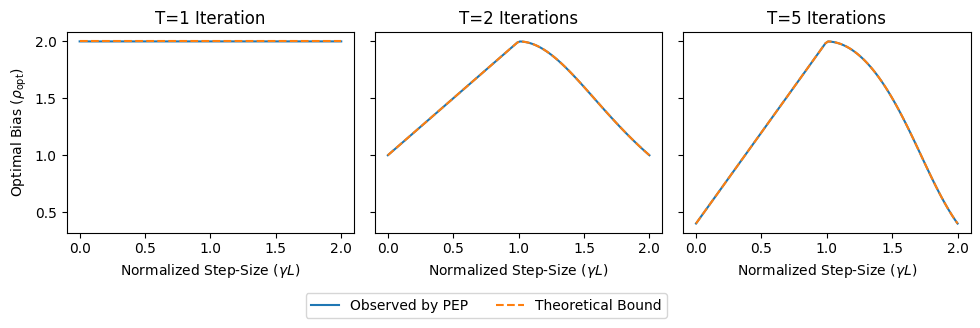

In [23]:
# Plot result with theoretical overlay for rates
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

# Theoretical rate
rate_theory = lambda gamma, T: min(
    2 * ((1 - 1 / T) * gamma + 1 / T),
    2 / sum((gamma - 1) ** (2 * i) for i in range(T))
)

for i, (T, inst, ax) in enumerate(zip(Ts, instances, axs.flatten())):
    # Plot empirical results
    ax.plot(GAMMAS, [r.param.bias.value if r else None for r in inst], label="Observed by PEP")

    # Plot theoretical bound
    ax.plot(GAMMAS, [rate_theory(gamma, T) for gamma in GAMMAS], "--", label="Theoretical Bound")

    # Axis metadata
    ax.set_title(f"T={T} Iteration{'s' if T > 1 else ''}")
    ax.set_xlabel(r"Normalized Step-Size ($\gamma L$)")
    if i == 0: ax.set_ylabel(r"Optimal Bias ($\rho_{\text{opt}}$)")

# Get and show legend
handles, labels = axs.flatten()[0].get_legend_handles_labels()
plt.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.show()

/var/folders/_m/ybhbkgw97lx48djbw4jxvclh0000gn/T/ipykernel_80169/2926522699.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return (N - k) / (N - k - 1 + 1 / gamma) * (N - 1 + 1 / gamma) / N
/var/folders/_m/ybhbkgw97lx48djbw4jxvclh0000gn/T/ipykernel_80169/2926522699.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  return (N - k) / (N - k - 1 + 1 / gamma) * (N - 1 + 1 / gamma) / N


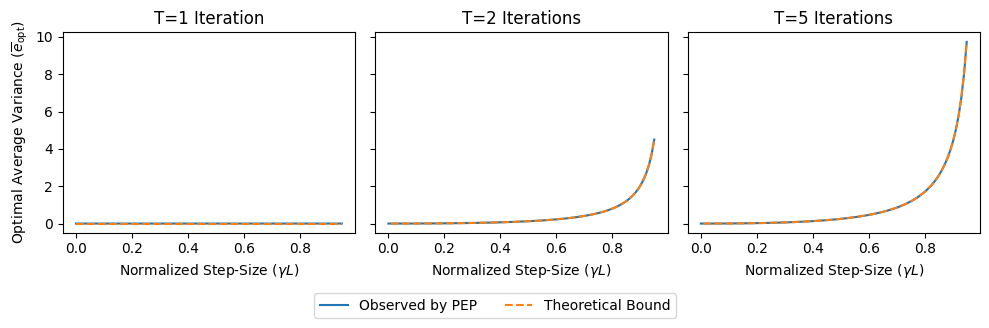

In [21]:
# Plot result with theoretical overlay for rates
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

# Theoretical variance
def var_short_theory(gamma, N):
    theory_rate = lambda gamma, N: min(
        2 * ((1 - 1 / N) * gamma + 1 / N),
        2 / sum((gamma - 1) ** (2 * i) for i in range(N)))
    def ak_theory(k):
        return (N - k) / (N - k - 1 + 1 / gamma) * (N - 1 + 1 / gamma) / N

    absum = lambda k: theory_rate(gamma, N) + 4 * gamma * ak_theory(k + 1) * (0 if gamma < 1 else (gamma - 1))
    try:
        return sum(1 / (1 / (ak_theory(k + 1) * gamma ** 2) - 2 / absum(k)) for k in range(N - 1)) / N
    except ZeroDivisionError:
        return 0
    
for i, (T, inst, ax) in enumerate(zip(Ts, instances_short, axs.flatten())):
    # Plot empirical results
    ax.plot(GAMMAS_SHORT, [r.param.variance_avg.value if r else None for r in inst], label="Observed by PEP")

    # Plot theoretical bound
    ax.plot(GAMMAS_SHORT, [var_short_theory(gamma, T) for gamma in GAMMAS_SHORT], "--", label="Theoretical Bound")

    # Axis metadata
    ax.set_title(f"T={T} Iteration{'s' if T > 1 else ''}")
    ax.set_xlabel(r"Normalized Step-Size ($\gamma L$)")
    if i == 0: ax.set_ylabel(r"Optimal Average Variance ($\overline{e}_{\text{opt}}$)")

# Get and show legend
handles, labels = axs.flatten()[0].get_legend_handles_labels()
plt.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.show()

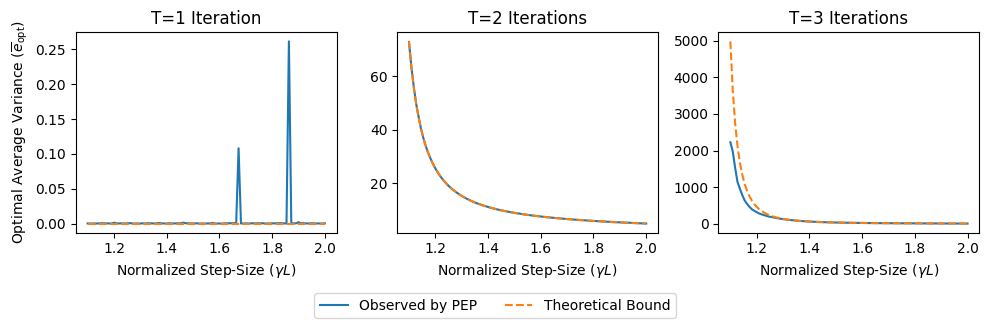

In [22]:
# Plot result with theoretical overlay for rates
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Theoretical variance
def var_long_theory(gamma, N):
    theta = (1 - gamma) ** 2
    rho = 2 / (sum(theta ** (i) for i in range(N)))
    a = lambda t: sum(theta ** (i) for i in range(N-t)) / sum(theta ** (i) for i in range(N))
    e = lambda t: a(t+1) * gamma ** 2 * (rho + 4 * a(t+1) * gamma * (gamma - 1)) / (-2 * a(t+1) * gamma ** 2 + rho + 4 * a(t+1) * gamma * (gamma - 1))
    return sum(e(t) for t in range(N)) / N
    
for i, (T, inst, ax) in enumerate(zip(Ts_long, instances_long, axs.flatten())):
    # Plot empirical results
    ax.plot(GAMMAS_LONG, [r.param.variance_avg.value if r else None for r in inst], label="Observed by PEP")

    # Plot theoretical bound
    ax.plot(GAMMAS_LONG, [var_long_theory(gamma, T) for gamma in GAMMAS_LONG], "--", label="Theoretical Bound")

    # Axis metadata
    ax.set_title(f"T={T} Iteration{'s' if T > 1 else ''}")
    ax.set_xlabel(r"Normalized Step-Size ($\gamma L$)")
    if i == 0: ax.set_ylabel(r"Optimal Average Variance ($\overline{e}_{\text{opt}}$)")

# Get and show legend
handles, labels = axs.flatten()[0].get_legend_handles_labels()
plt.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.show()